# Specialisation query using NNApex
Code to recreate the NNapex Peacock code from Matlab
This performs performs poly queries using the NNapex using the perfect point method.

In [1]:
from pathlib import Path
from sisap2023.utils.mirflickr import load_encodings, set_mf_images_path

data_root = Path("/Volumes/Data")

# set the location of the mirflickr images so they can be displayed
set_mf_images_path(data_root / "mf" / "images")

# load the dino2 image embeddings and the resnet19 softmax activations
data = load_encodings(data_root / "mf_dino2")
sm_data = load_encodings(data_root / "mf_resnet19_softmax")

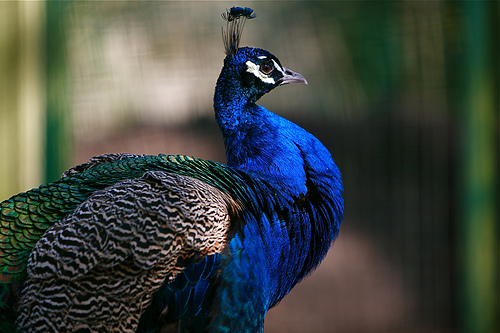

In [2]:
# Get the peacock at index 

from sisap2023.utils.mirflickr import get_mf_image

q0 = 101102 # a peacock

get_mf_image(q0)

In [3]:
import numpy as np
from sisap2023.utils.distances import get_euc_dists


dists = get_euc_dists(q0, data)
closest_indices = np.argsort(dists) # the closest images to the query
best_100_for_one = closest_indices[0:100]

In [4]:
from sisap2023.utils.count_cats import get_best_cats_in_subset

peacock_category = 84

best_100_categorical = get_best_cats_in_subset(peacock_category,best_100_for_one,sm_data)

# These are the indices that might be chosen by a human ..

poly_query_indexes = best_100_categorical[0:6] # These are the indices we will use for the poly query


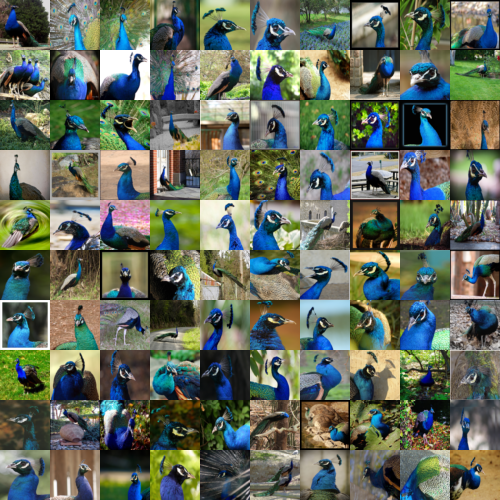

In [5]:
# These are the best images best on lowest average distance from the queries

from sisap2023.utils.mirflickr import make_mf_image_grid

make_mf_image_grid(best_100_categorical,10,10,50,50)

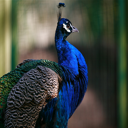

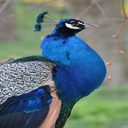

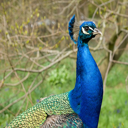

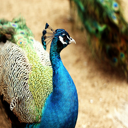

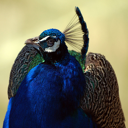

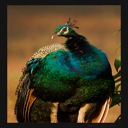

In [6]:
dists = get_euc_dists(q0, data)
closest_indices = np.argsort(dists) # the closest images to the query

poly_query_indexes = closest_indices[0:6] # These are the indices we will use for the poly query

for i in range(0,6): # 0 is the original image
    display(get_mf_image(poly_query_indexes[i], (128, 128)))

poly_query_data = data[poly_query_indexes]

In [7]:
# Fetch the data and whole-set distances for the extra query objects
num_poly_queries = len(poly_query_indexes)

print(num_poly_queries)
print(poly_query_data.shape)

poly_query_distances = np.zeros((num_poly_queries,1000*1000))
for i in range(num_poly_queries):
    poly_query_distances[i] = get_euc_dists(poly_query_indexes[i], data) 

6
(6, 384)


In [8]:
# Here we will use some estimate of the nn distance to each query to construct a
# new point in the nSimplex projection space formed by the poly query objects

nnToUse = 10

ten_nn_dists = np.zeros(num_poly_queries);

for i in range(num_poly_queries):
    sortedDists = np.sort(poly_query_distances[i])
    ten_nn_dists[i] = sortedDists[nnToUse]


In [9]:
import math 
from sisap2023.metrics.euc import euc_scalar
from sisap2023.metrics.nsimplex import NSimplex

def fromSimplexPoint(poly_query_distances : np.array, inter_pivot_distances : np.array, nn_dists:  np.array) -> np.array:
    '''poly_query_data is the set of reference points with which to build the simplex'''
    '''inter_pivot_distances are the inter-pivot distances with which to build the base simplex'''
    '''nn_dists is a column vec of distances, each abit more than the nn distance from each ref to the rest of the data set'''
    '''ie the "perfect" intersection to the rest of the set'''
    '''returns a np.array of distances between the perfect point and the rest of the data set'''

    nsimp = NSimplex()
    nsimp.build_base(inter_pivot_distances,False)

    # second param a (B,N)-shaped array containing distances to the N pivots for B objects.
    perfPoint = nsimp._get_apex(nsimp._base,nn_dists)    # was projectWithDistances in matlab

    for i in range(1000 * 1000):
        distvec = poly_query_distances[:,i]                      # a row vec of distances
        pr = nsimp._get_apex(nsimp._base,np.transpose(distvec))
        dists[i] = euc_scalar(pr,perfPoint)  # is this right - see comment in simplex_peacock on this!   <<<< ERROR Ghosts dists

    return dists


In [10]:
# from Italian documentation: README.md line 25
from scipy.spatial.distance import pdist, squareform

inter_pivot_distances = squareform(pdist(poly_query_data, metric=euc_scalar)) # pivot-pivot distance matrix with shape (n_pivots, n_pivots)

In [11]:
distsToPerf = fromSimplexPoint(poly_query_distances,inter_pivot_distances,ten_nn_dists);  # was multipled by 1.1 in some versions!

/Users/dm236/development/sisap2023/sisap2023/metrics/nsimplex.py:43: RuntimeWarning: invalid value encountered in sqrt
  z = np.sqrt((y_n ** 2) - (w ** 2))
/Users/dm236/development/sisap2023/sisap2023/metrics/nsimplex.py:48: UserWarning: one or more points does not satisfies the n-point property, or the max dim was reached (diff for vertex-pivot 1 is [-5.5863031e-13])
  warnings.warn(f"one or more points does not satisfies the n-point property, or the max dim was reached (diff for vertex-pivot {k} is {diff})")
/Users/dm236/development/sisap2023/sisap2023/metrics/nsimplex.py:48: UserWarning: one or more points does not satisfies the n-point property, or the max dim was reached (diff for vertex-pivot 2 is [9.42912195e-05])
  warnings.warn(f"one or more points does not satisfies the n-point property, or the max dim was reached (diff for vertex-pivot {k} is {diff})")
/Users/dm236/development/sisap2023/sisap2023/metrics/nsimplex.py:48: UserWarning: one or more points does not satisfies the 

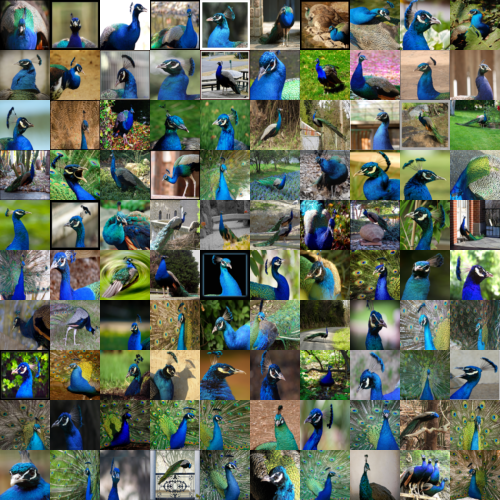

In [12]:
closest_indices = np.argsort(distsToPerf) # the closest images to the perfect point

best_100_for_perfect_point = closest_indices[0:100]

make_mf_image_grid(best_100_for_perfect_point,10,10,50,50)

In [13]:
# Now want to report results the total count in the category

from sisap2023.utils.count_cats import count_number_in_results_in_cat

peacock_category = 84

encodings_for_best_100_single = sm_data[best_100_for_one] # the alexnet encodings for the best 100 average singlequery images
single_peacock_totals = encodings_for_best_100_single[:,peacock_category]
print("Total peacock sum for single query best 100: ", np.sum(single_peacock_totals))


encodings_for_best_100_average = sm_data[best_100_for_perfect_point] # the alexnet encodings for the best 100 polyquery images
average_peacock_totals = encodings_for_best_100_average[:,peacock_category]
print("Total peacock sum for poly query best 100: ", np.sum(average_peacock_totals))

res = count_number_in_results_in_cat(peacock_category,0.9,best_100_for_one,sm_data)
print("Total with thresh better than 0.9 single query : ", res)

res = count_number_in_results_in_cat(peacock_category,0.9,best_100_for_perfect_point,sm_data)
print("Total with thresh better than 0.9 poly query : ", res)

Total peacock sum for single query best 100:  98.88239
Total peacock sum for poly query best 100:  98.659386
Total with thresh better than 0.9 single query :  98
Total with thresh better than 0.9 poly query :  97
